<a href="https://colab.research.google.com/github/pachterlab/monod_examples/blob/dev/Monod_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset. 

# Inference pipeline

## Define aesthetics

In [1]:
import time
t1 = time.time()
#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


## Install prerequisites

In [2]:
# %%capture
!pip install -i https://test.pypi.org/simple/ -U --extra-index-url https://pypi.org/simple   monod  
# !pip install -i https://pypi.org/simple/  monod  

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.org/simple
     |████████████████████████████████| 44 kB 792 kB/s 
     |████████████████████████████████| 100 kB 3.4 MB/s 
     |████████████████████████████████| 96 kB 2.2 MB/s 
     |████████████████████████████████| 4.8 MB 39.7 MB/s 
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=31b6b0b4d39940bf498f00bb45039240ee250f542d5ea4824b30e4521d6f078f
  Stored in directory: /root/.cache/pip/wheels/51/a8/38/34cd3ac301d305904452deca6780940beb70d059798042fd63
Successfully built loompy


Let's make sure that the version is correct.

In [2]:
!pip show monod

Name: monod
Version: 0.2.5.0
Summary: the Monod package fits CME models to sequencing data.
Home-page: https://github.com/pachterlab/monod
Author: Gennady Gorin, Lior Pachter
Author-email: ggorin@caltech.edu, lpachter@caltech.edu
License: None
Location: /usr/local/lib/python3.8/dist-packages
Requires: numdifftools, loompy, pytz, anndata, scipy, numpy
Required-by: 


## Import data

In [4]:
! git clone https://github.com/pachterlab/monod_examples.git

Cloning into 'monod_examples'...
remote: Enumerating objects: 956, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 956 (delta 90), reused 334 (delta 86), pack-reused 616
Receiving objects: 100% (956/956), 863.52 MiB | 30.34 MiB/s, done.
Resolving deltas: 100% (268/268), done.
Checking out files: 100% (96/96), done.


In [5]:
!rm -r sample_data

In [6]:
!mv monod_examples/* .

In [7]:
!mv sample_data/* .

In [8]:
!tar -xzvf allen_C01_gaba.tar.gz

allen_C01_gaba.loom


In [9]:
!cat allen_C01_glu.tar.gz.001 allen_C01_glu.tar.gz.002 | tar -xzv

allen_C01_glu.loom


We can construct an `anndata` object with `spliced` and `unspliced` layers, in line with standard workflows.

In [ ]:
import anndata as ad

In [ ]:
a = ad.read_loom('allen_C01_glu.loom')
a.write('allen_C01_glu.h5ad')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
b = ad.read_loom('allen_C01_gaba.loom')
b.write('allen_C01_gaba.h5ad')

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Import package components

In [1]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


## Define metadata

In [2]:
dataset_names = ['allen_C01_gaba','allen_C01_glu'] 
loom_filepaths = ['./'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=[('unspliced','spliced'),'gene_name','barcode']

In [3]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

## Run pre-processing

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221206_025_mouse_1 created.
INFO:root:Dataset: allen_C01_gaba
INFO:root:1704 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6284 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221206_025_mouse_1/allen_C01_gaba created.
INFO:root:Dataset: allen_C01_glu
INFO:root:4674 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7049 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221206_025_mouse_1/allen_C01_glu created.
INFO:root:Gene set size according to a 100.0% dataset threshold: 5810
INFO:root:250 random genes selected.
INFO:root:Total of 250 genes selected.
INFO:root:Directory ./fits/gg_221206_025_mouse_1/diagnostic_figures created.


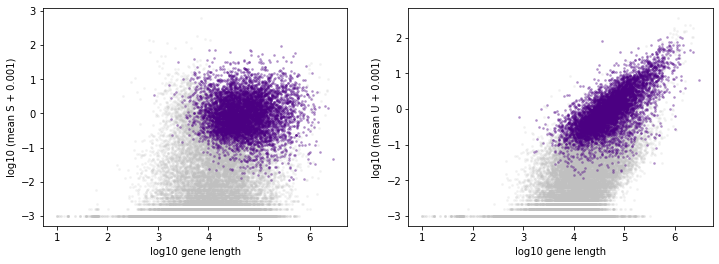

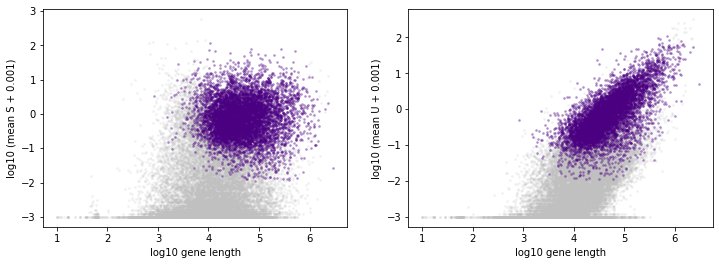

In [13]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='mouse',batch_id=1,\
                                             n_genes=250)

## Run inference

In this example, we will fit the bursty model to the two cell types, using a Poisson sampling model on a $6\times 7$ grid. For this Colaboratory notebook, we only use 5 iterations from the MoM estimate.

INFO:root:Directory ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7 created.
INFO:root:Global inference parameters stored to ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01_gaba
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221206_025_mouse_1/genes.csv.
INFO:root:Directory ./fits/gg_221206_025_mouse_1/allen_C01_gaba/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221206_025_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures created.
INFO:root:Runtime: 677.3 seconds.
INFO:root:Directory ./fits/gg_221206_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7 create

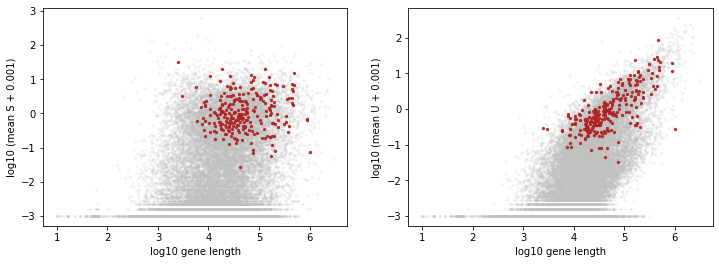

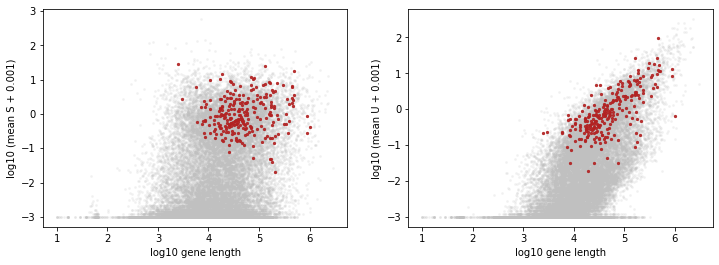

In [15]:
n_datasets = len(dataset_names)
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
grid = [6,7]

result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(lb,ub,[-8, -3],[-5, 0],grid,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                        dataset_strings[i], dir_string, dataset_attr_names=attribute_names)
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings.append(full_result_string)


In [16]:
%%capture
!tar -czvf sample_fits.tar.gz fits

# Analysis

## Post-processing and QC

Load in search data.

In [4]:
dir_string = './fits/gg_221206_025_mouse_1'
dataset_strings = [dir_string+'/'+x for x in dataset_names]
result_strings = [x+'/Bursty_Poisson_6x7/grid_scan_results.res' for x in dataset_strings]

sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(x+'/raw.sd') for x in dataset_strings]

INFO:root:Grid scan results loaded from ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_221206_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221206_025_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_221206_025_mouse_1/allen_C01_glu/raw.sd.


Inspect all bursty result files and perform basic QC. We would like to be confident of the typical results:

*   The fits successfully recapitulate the joint count distributions
*   The sampling parameters appear to have a single unique optimum in $\{C_u, \lambda_s\}$
*   The physical parameters $\{b,\beta,\gamma\}$ are largely independent of gene length
*   The physical parameter distributions are consistent with a normal-inverse Gaussian law

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def run_qc(j):
    sr = sr_arr[j]
    sd = sd_arr[j]
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)



    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,viz=True) 

    sr.compute_sigma(sd,num_cores=1) #colab has a hard time with multiprocessing
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()


INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 36 genes out of 250. Runtime: 1.5 seconds.
INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 36 genes out of 250. Runtime: 1.7 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 36 genes out of 250. Runtime: 1.6 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation

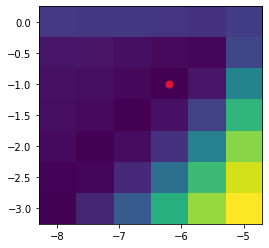

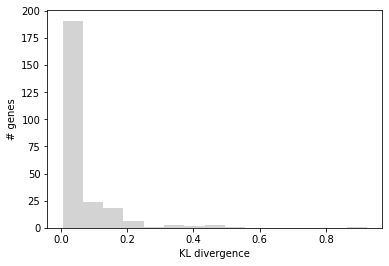

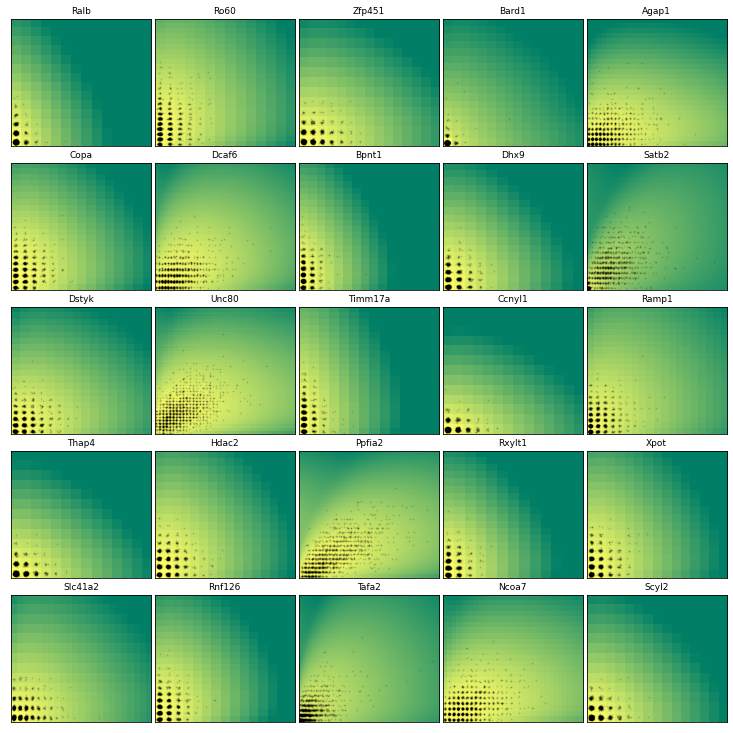

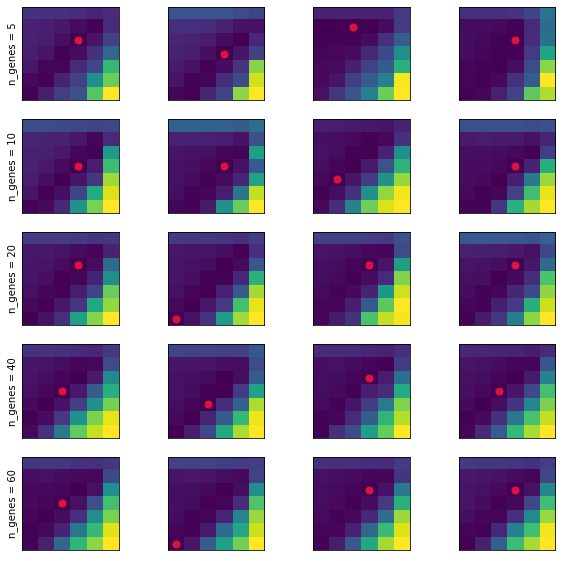

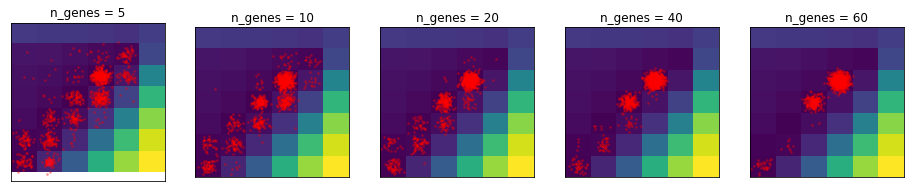

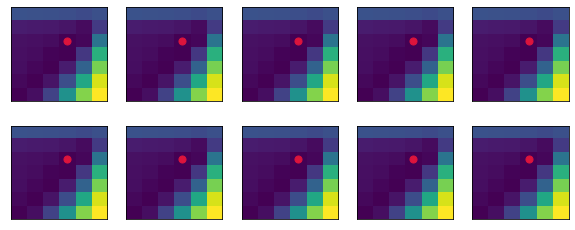

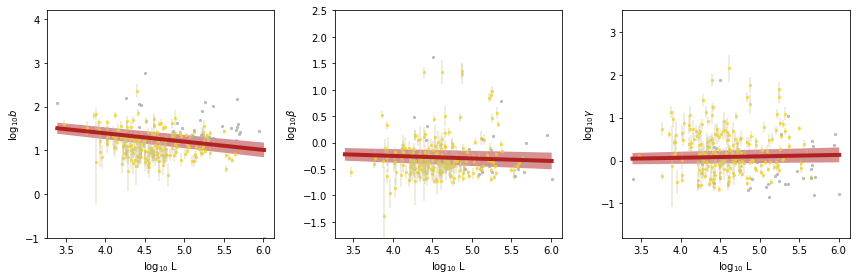

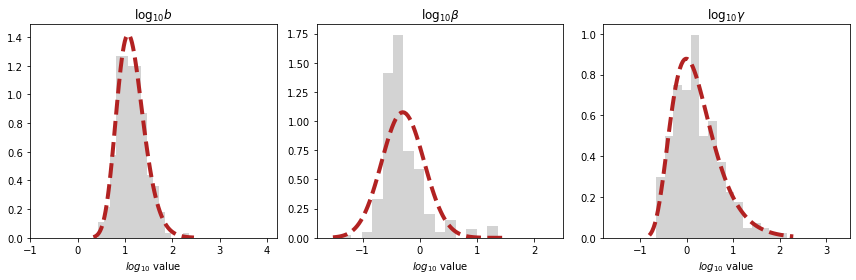

In [10]:
run_qc(0)

INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 16 genes out of 250. Runtime: 1.9 seconds.
INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 16 genes out of 250. Runtime: 2.1 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 16 genes out of 250. Runtime: 2.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation com

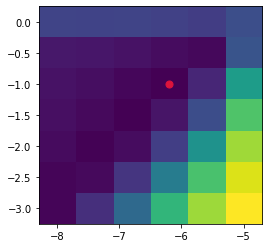

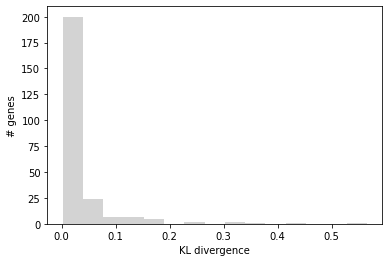

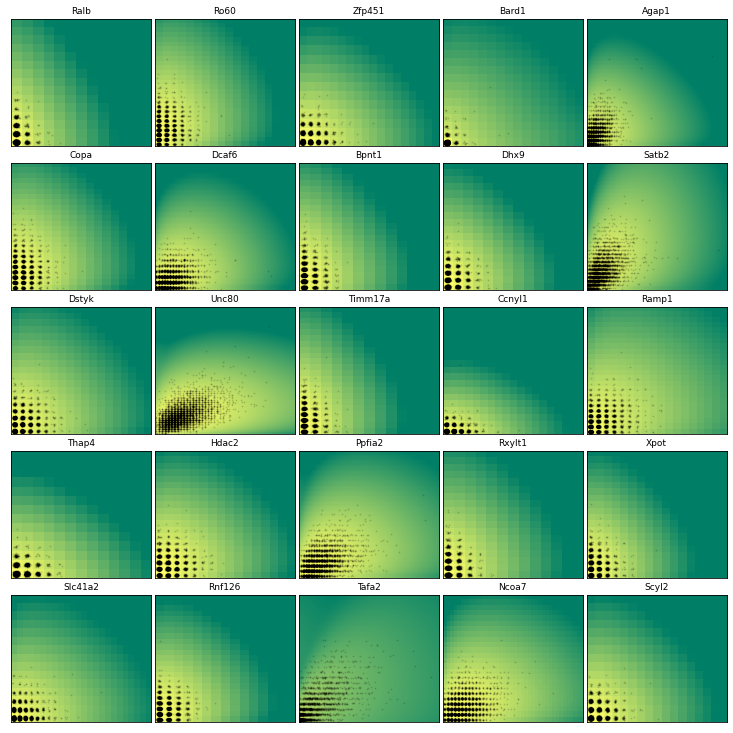

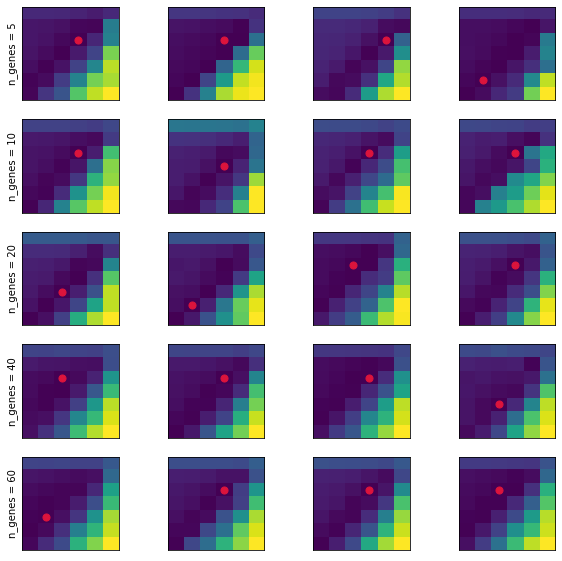

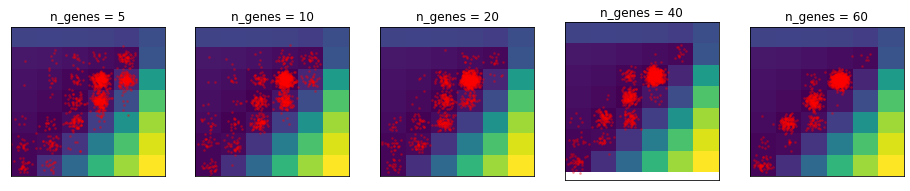

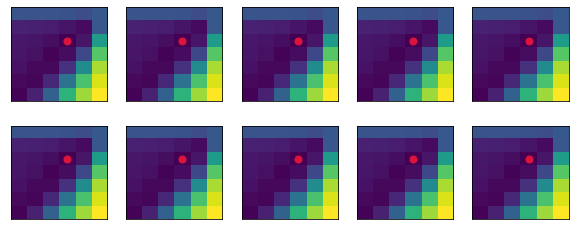

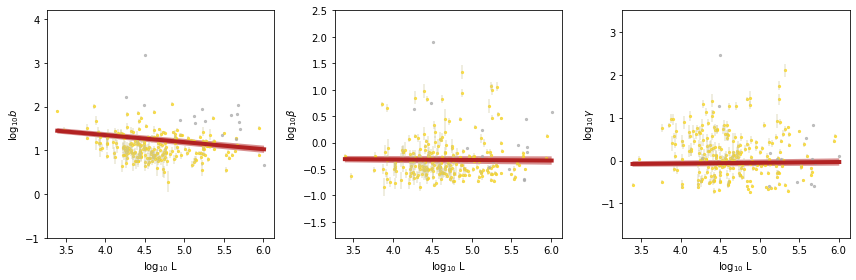

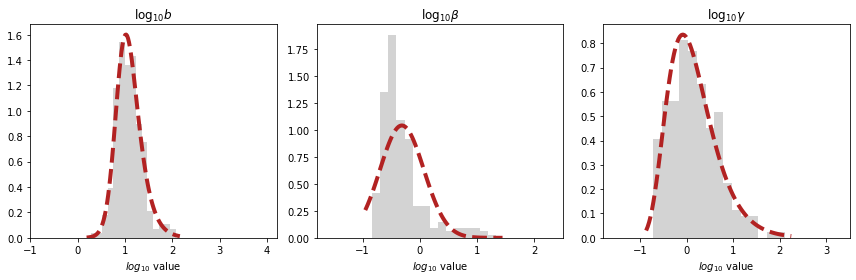

In [7]:
run_qc(1)

In [8]:
%%capture
!tar -czvf sample_fits_upd.tar.gz fits

# Analysis of differential expression.

Load in pre-computed sample results. 

In [9]:
dir_string = './fits/gg_221206_025_mouse_1'
dataset_strings = [dir_string+'/'+x for x in dataset_names]
result_strings = [x+'/Bursty_Poisson_6x7/grid_scan_results_upd.res' for x in dataset_strings]

Finally, we can analyze the four mouse datasets in terms of differences between their mRNA copy number distributions, potentially suggesting differential regulation of their transcriptional processes.

In [10]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(x+'/raw.sd') for x in dataset_strings]

INFO:root:Grid scan results loaded from ./fits/gg_221206_025_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221206_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_221206_025_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_221206_025_mouse_1/allen_C01_glu/raw.sd.


In [11]:
gn=sr_arr[0].gene_names
param_names = sr_arr[0].model.get_log_name_str()
n_phys_pars = sr_arr[0].sp.n_phys_pars
n_genes = sr_arr[0].n_genes
param_names_text = ('log10 b','log10 beta','log10 gamma','log10 ki')
n_genes = sd_arr[0].n_genes
pval_thr = 0.1

## Standard differential expression: DE-$\mu$

The means are very similar between the datasets.

In [12]:
import matplotlib.pyplot as plt
import numpy as np

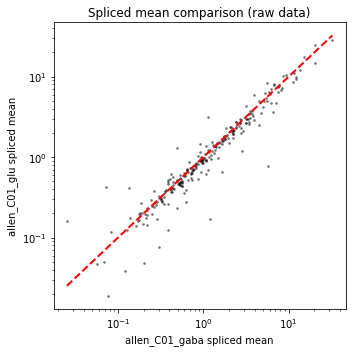

In [13]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
m1 = np.asarray([sd_arr[0].moments[x]['S_mean']  for x in range(n_genes)])
m2 = np.asarray([sd_arr[1].moments[x]['S_mean'] for x in range(n_genes)])
ax1.scatter(m1,m2,3,'k',alpha=0.4)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(dataset_names[0] + ' spliced mean')
ax1.set_ylabel(dataset_names[1] + ' spliced mean')
ax1.set_title('Spliced mean comparison (raw data)')
xl = [min(m1),max(m1)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Raw means show changes of up to an order of magnitude.

In [14]:
print((m1/m2).min())
print((m1/m2).max())

0.1558086962993283
7.50792375680673


<>:7: DeprecationWarning: invalid escape sequence \l
<>:7: DeprecationWarning: invalid escape sequence \l
<ipython-input-15-18c700ed5b6a>:7: DeprecationWarning: invalid escape sequence \l
  ax1.set_title('Normalized + $\log_2$ transformed')


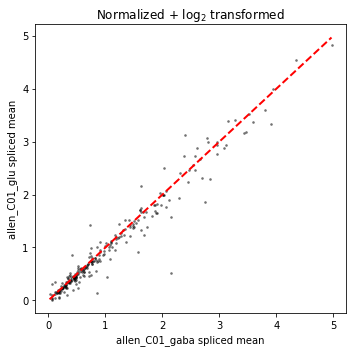

In [15]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
m1norm = monod.extract_data.normalize_count_matrix(sd_arr[0].layers[1],logbase=2).mean(1)
m2norm = monod.extract_data.normalize_count_matrix(sd_arr[1].layers[1],logbase=2).mean(1)
ax1.scatter(m1norm,m2norm,3,'k',alpha=0.4)
ax1.set_xlabel(dataset_names[0] + ' spliced mean')
ax1.set_ylabel(dataset_names[1] + ' spliced mean')
ax1.set_title('Normalized + $\log_2$ transformed')
xl = [min(m1norm),max(m1norm)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

The differences between means of normalized data are very small, less than a twofold change. Note we subtract here, because we have applied a $\log_2$ transformation to the raw data. 

In [16]:
print((m1norm-m2norm).min())
print((m1norm-m2norm).max())

-0.730386430692715
1.6333998485417336


Accordingly, the $t$-test identifies nothing.

/usr/local/lib/python3.8/dist-packages/monod/analysis.py:988: RuntimeWarning: divide by zero encountered in log10
  pv = -np.log10(p)


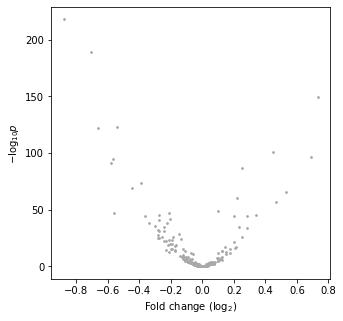

In [17]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
gf_ttest,fc_ = monod.analysis.diffexp_mean(sd_arr[0],sd_arr[1],lognormalize=True,viz=True,method='ttest',\
                                ax1=ax1,pval_thr=pval_thr,bonferroni=True)
fig_string = sr_arr[0].batch_analysis_string+'/ttest_s.png'
plt.savefig(fig_string,dpi=450)

## DE-$\theta$

With the parameter fits, we can attempt to identify genes that show differences in distributions, which are not necessarily reflected in the means.

Inspect the parameter trends. These are slightly less correlated than means.

INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/analysis_figures/pair_parameter_comparison_mouse.png.


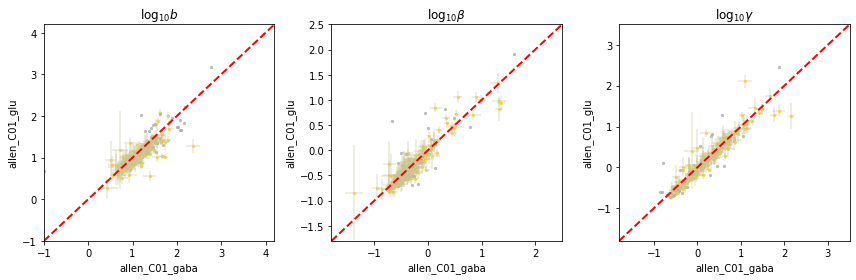

In [18]:
monod.analysis.plot_params_for_pair(sr_arr[0],sr_arr[1],\
                        distinguish_rej=True,plot_errorbars=True,meta = 'mouse',
                        xlabel = dataset_names[0],\
                        ylabel = dataset_names[1])

A handful of genes can be identified as outliers.

INFO:root:Figure stored to ./fits/gg_221206_025_mouse_1/analysis_figures/parameter_residuals_mouse.png.


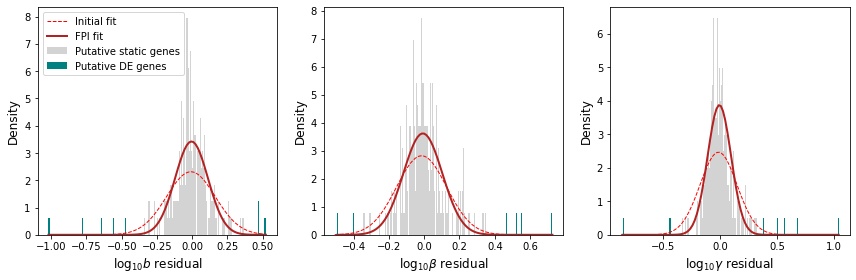

In [19]:
dr_analysis = monod.analysis.diffexp_pars(sr_arr[0],sr_arr[1],viz=True,modeltype='id',meta= 'mouse',use_sigma=True)

In [20]:
dr_par = dr_analysis[1].T
fc_par = dr_analysis[3].T
dr_par = np.concatenate((dr_par,((dr_par[:,1] & dr_par[:,2]))[:,None]),1)
fc_par = np.concatenate((fc_par,(-(fc_par[:,1]+fc_par[:,2])/2)[:,None]),1)

What are these genes? 

In [21]:
for k in range(n_phys_pars+1):
    print(param_names_text[k])
    print(gn[dr_par[:,k]])

log10 b
['Egln3' 'Eif3l' 'Arfrp1' 'Vav2' 'Trpc3' 'Mob3b' 'Lgi2' 'Eps8' 'Egln1']
log10 beta
['Eif3l' 'Arfrp1' 'Sertm1' 'Plpp3' 'Mob3b' 'Susd5']
log10 gamma
['Egln3' 'Eif3l' 'Arfrp1' 'Sertm1' 'Plpp3' 'Mob3b' 'Bcl7c' 'Susd5']
log10 ki
['Eif3l' 'Arfrp1' 'Sertm1' 'Plpp3' 'Mob3b' 'Susd5']


We have identified some genes as frequency-modulated. Is frequency modulation common in general?

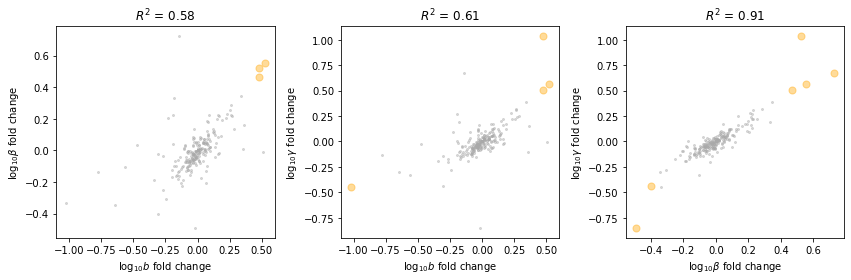

In [22]:
pairs = [[0,1],[0,2],[1,2]]
q=0
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
    gf = dr_par[:,k1] & dr_par[:,k2]

    x = fc_par[:,k1]
    y = fc_par[:,k2]
    x[np.isnan(x)] = 0 
    y[np.isnan(y)] = 0

    ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(param_names[k1]+' fold change')
    ax1[q].set_ylabel(param_names[k2]+' fold change')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()


## Raw data examination

### Burst size

Do the fit distributions actually match the data? First, consider those assigned to burst size modulation.

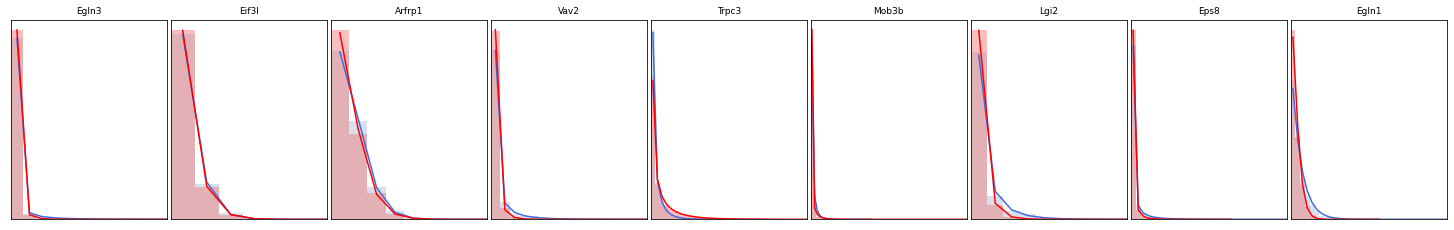

In [23]:
gf = dr_par[:,0]
monod.analysis.compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(1,9),figsize=(20,3))

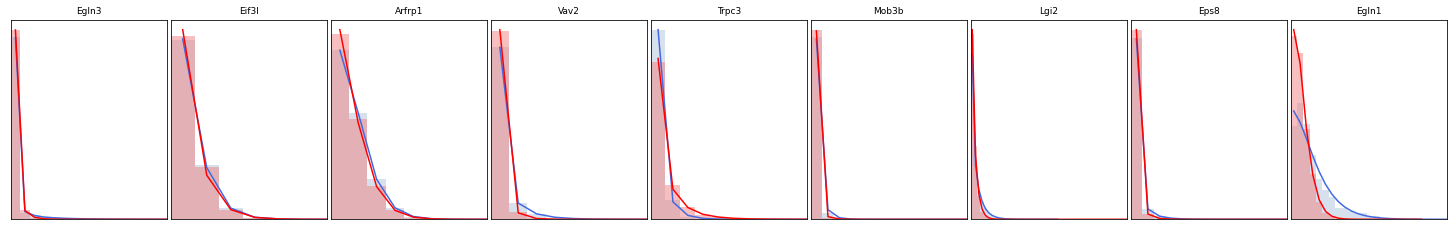

In [24]:
monod.analysis.compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(1,9),figsize=(20,3))

They appear to match the data fairly well, altough *Tsnax* shows some subtle deviations in the mature mRNA distribution.

How much do the parameters change? The model predicts above 0.5 absolute $\log_2$ change.

In [25]:
fc_par[gf][:,0]

array([-1.01963939,  0.4765286 ,  0.5228293 , -0.77503542,  0.50785286,
        0.47580001, -0.56372274, -0.47233622, -0.64516565])

How much do the means change? After normalization, less than 0.6.

In [26]:
fc_[gf]

array([-0.1254003 , -0.01932242, -0.08286659, -0.13594281,  0.21689332,
       -0.05722386, -0.27557909, -0.07424894, -0.66062083])

Raw averages do change more than twofold for *Grin3a*.

In [27]:
(m1/m2)[gf]

array([3.98345268, 1.04475537, 1.15208024, 4.22366945, 0.32278311,
       4.08326665, 1.7565645 , 3.1436145 , 2.361542  ])

### Burst frequency

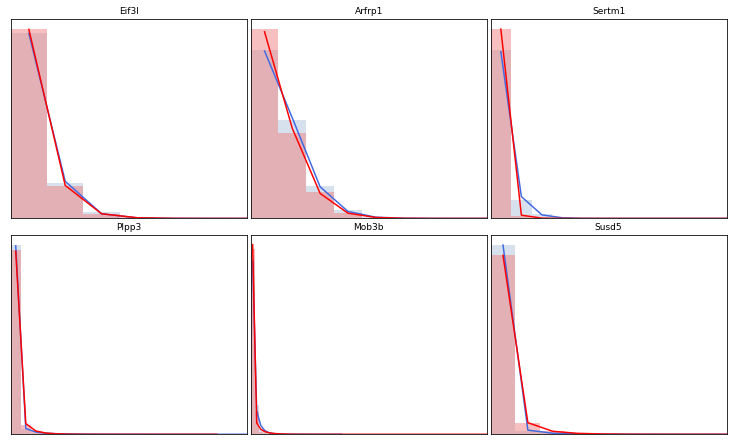

In [28]:
gf = dr_par[:,3]
monod.analysis.compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(2,3),figsize=(10,6))

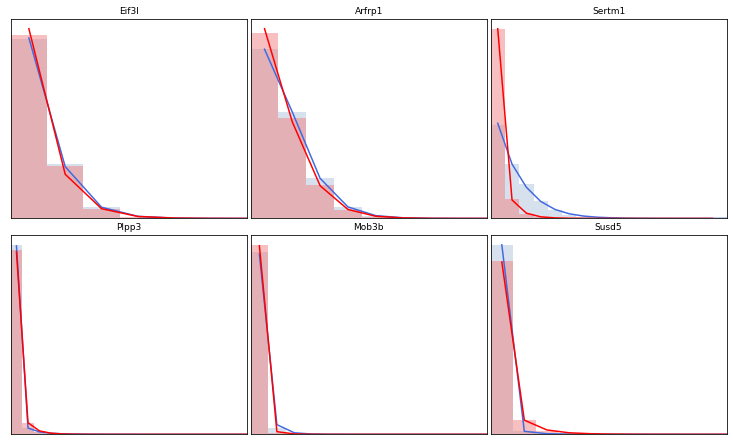

In [29]:
monod.analysis.compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(2,3),figsize=(10,6))

The differences for frequency-modulated genes are more subtle. They predict approximately $\log_2$ fold change of -0.65 from GABAergic to glutamatergic.  The $\log_2$ fold change between averages after normalization is less than 0.1.

In [30]:
fc_par[gf][:,3]

array([-0.48878326, -0.56046117, -0.70079199,  0.41761452, -0.78100085,
        0.67275285])

In [31]:
fc_[gf]

array([-0.01932242, -0.08286659, -0.7061887 ,  0.02327287, -0.05722386,
        0.10116327])

If we look at the difference between raw averages, it is less than twofold.

In [32]:
(m1/m2)[gf]

array([1.04475537, 1.15208024, 7.06424606, 0.7018018 , 4.08326665,
       0.1558087 ])

In [ ]:
!tar -czvf sample_fits.tar.gz fits

fits/
fits/gg_221201_025_mouse_1/
fits/gg_221201_025_mouse_1/genes.csv
fits/gg_221201_025_mouse_1/analysis_figures/
fits/gg_221201_025_mouse_1/analysis_figures/pair_parameter_comparison_mouse.png
fits/gg_221201_025_mouse_1/analysis_figures/ttest_s.png
fits/gg_221201_025_mouse_1/analysis_figures/parameter_residuals_mouse.png
fits/gg_221201_025_mouse_1/allen_C01_glu/
fits/gg_221201_025_mouse_1/allen_C01_glu/raw.sd
fits/gg_221201_025_mouse_1/allen_C01_glu/diagnostic_figures/
fits/gg_221201_025_mouse_1/allen_C01_glu/diagnostic_figures/allen_C01_glu.png
fits/gg_221201_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/
fits/gg_221201_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results.res
fits/gg_221201_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/
fits/gg_221201_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/length_dependence.png
fits/gg_221201_025_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/chisquare_stability.png
fits/gg_221201_025_mouse